In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import jax
import jax.numpy as jnp
import scipy
from scipy.optimize import fmin_l_bfgs_b
from time import time
from picard import amari_distance
from multiviewica_delay import multiviewica_delay

# temporary data generation

In [104]:
from multiviewica_delay import (
    generate_data,
    data_generation,
    data_generation_pierre,
)

# params
m = 5
p = 2
n = 600
max_delay = 10
shared_delays = False
random_state = 42
generation_function = "first"
if generation_function == "first":
    nb_intervals = 5
    nb_freqs = 10
    treshold = 1
    noise = 0.8
elif generation_function == "second":
    n_concat = 1
    noise = 0.01
else:
    n_bins = 10
    n_samples_per_interval = n // n_bins
    freq_level = 40
    noise = 0.2

# generate sources
if generation_function == "first":
    X_list, A_list, true_tau_list, S_list, S = generate_data(
        m=m,
        p=p,
        n=n,
        nb_intervals=nb_intervals,
        nb_freqs=nb_freqs,
        treshold=treshold,
        delay=max_delay,
        noise=noise,
        random_state=random_state,
        shared_delays=shared_delays
    )
elif generation_function == "second":
    X_list, A_list, true_tau_list, S_list, S = data_generation(
        m=m,
        p=p,
        n=n,
        max_delay=max_delay,
        noise=noise,
        shared_delays=shared_delays,
        random_state=random_state,
        n_concat=n_concat,
    )
else:
    X_list, A_list, true_tau_list, S_list, S = data_generation_pierre(
        n_subjects=m,
        n_sources=p,
        n_bins=n_bins,
        n_samples_per_interval=n_samples_per_interval,
        freq_level=freq_level,
        max_delay=max_delay,
        noise=noise,
        shared_delays=shared_delays,
        random_state=random_state,
    )

# generate data

In [82]:
# params
m = 5
p = 2
n = 600
nb_freqs = 3
noise_data = 0.3  # noise in the generated data
noise_model = 1  # noise assumed in the model
max_dilation = 1
max_shift = 20
t0 = n / 4
random_state = 42
rng = check_random_state(random_state)

In [83]:
def apply_both_delays_1d(s, a=1, b=0, t0=0):
    t = jnp.arange(len(s)) - t0
    t_ab = (t - b) * a  
    # by writing (t-b)*a instead of t*a-b we allow the constant delay to be measurable in sample unit, 
    # i.e. constant_delay=5 means 5 samples, which corresponds to 5ms if the sampling rate is 1000Hz. 
    # It also means that we apply constant delay before cumulative delay, contrary to the paper on age-related delay.
    s_ab = jnp.interp(x=t_ab, xp=t, fp=s, left=0, right=0)
    return s_ab

def apply_both_delays_2d(S, a=None, b=None, t0=0):
    p, n = S.shape
    if a is None:  # if condition could cause a problem
        a = jnp.ones(p)
    if b is None:
        b = jnp.zeros(p)
    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    T_ab = ((T.T - b) * a).T
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t, fp=S[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d(S_list, A=None, B=None, t0=0):
    Y_list = jnp.array(
        [apply_both_delays_2d(S_list[i], a=A[i], b=B[i], t0=t0)
         for i in range(len(S_list))])
    return Y_list

# only works for shared_delays=False
def generate_synthetic_data(
    m=2,
    p=2,
    n=100,
    nb_freqs=3,
    noise_data=0.2,
    max_dilation=1.1,
    max_shift=20,
    t0=None,
    rng=None,
):
    if rng is None:
        rng = check_random_state(0)
    # create sources
    def generate_sources(p=2, n=100, nb_freqs=3, rng=None):
        def generate_one_source(n=100, nb_freqs=3, rng=None):
            heights = rng.exponential(scale=1, size=nb_freqs) / nb_freqs
            freq_max = 6  # arbitrary
            frequencies = rng.uniform(low=1, high=freq_max, size=nb_freqs)
            t = np.linspace(0, 1, n, endpoint=False)
            s = np.zeros(n)
            for i in range(nb_freqs):
                s += heights[i] * np.sin(2 * np.pi * frequencies[i] * t)
            return s
        S = np.vstack(
            [generate_one_source(n=n, nb_freqs=nb_freqs, rng=rng)
            for _ in range(p)])
        initial_delays = rng.randint(low=0, high=n, size=p)
        S = np.roll(S, initial_delays, axis=1)
        return S
    S = generate_sources(p=p, n=n, nb_freqs=nb_freqs, rng=rng)
    # add noise
    S_list = np.array([S] * m) + noise_data * rng.randn(m, p, n)
    # mixing matrices
    A_list = rng.randn(m, p, p)
    # add delay
    dilations = rng.uniform(low=1/max_dilation, high=max_dilation, size=(m, p))
    shifts = rng.uniform(low=-max_shift, high=max_shift, size=(m, p))
    if t0 is None:
        t0 = n / 4
    S_list = apply_both_delays_3d(S_list, A=dilations, B=shifts, t0=t0)
    # observed signals
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, dilations, shifts, S_list, S

X_list, A_list, dilations, shifts, S_list, S = generate_synthetic_data(
    m=m,
    p=p,
    n=n,
    nb_freqs=nb_freqs,
    noise_data=noise_data,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    rng=rng,
)

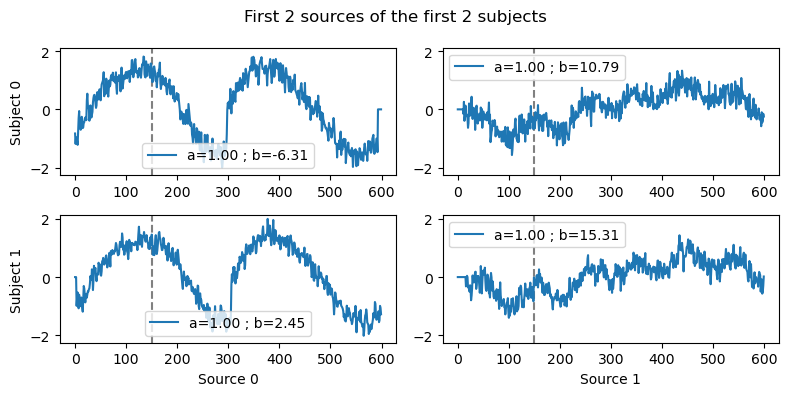

In [84]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

# W_list_init

In [105]:
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.1 * rng.randn(m, p, p)

# MVICAD

In [77]:
# MVICAD
_, W_mvicad, Y_mvicad, Y_list_mvicad, delays_mvicad, _ = multiviewica_delay(
    X_list,
    init=np.array(W_list_init),
    shared_delays=False,
    max_delay=max_shift,
    random_state=random_state,
    continuous_delays=False,
)
delays_mvicad[delays_mvicad > n // 2] -= n

In [75]:
print("MVICAD : ", np.mean([amari_distance(W, A) for W, A in zip(W_mvicad, A_list)]))

MVICAD :  0.7384101610773499


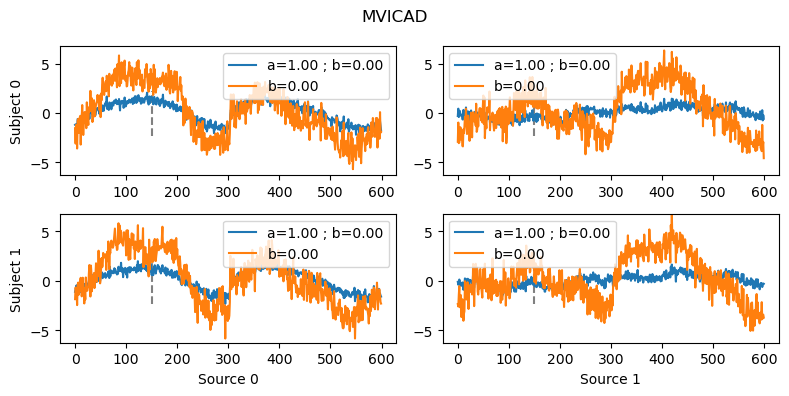

In [78]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.plot(
            Y_list_mvicad[i, j],
            label=f'b={delays_mvicad[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim(
            [min(np.min(S_list), np.min(Y_list_mvicad)), 
             max(np.max(S_list), np.max(Y_list_mvicad))])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"MVICAD")
plt.tight_layout()
plt.show()

# fmin_l_bfgs_b

In [79]:
def _logcosh(X):
    Y = jnp.abs(X)
    return Y + jnp.log1p(jnp.exp(-2 * Y))
    
# only works for shared_delays=False
def loss_function(W_list, dilations, shifts, X_list, noise_model=1, t0=0):
    _, p, _ = X_list.shape
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = apply_both_delays_3d(S_list, A=1/dilations, B=-shifts, t0=t0)
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

def vector_to_parameters(W_delays, m, p):
    W_list = W_delays[:m*p**2].reshape((m, p, p))
    dilations = W_delays[m*p**2: m*p*(p+1)].reshape((m, p))
    shifts = W_delays[m*p*(p+1):].reshape((m, p))
    return W_list, dilations, shifts

def parameters_to_vector(W_list, dilations, shifts):
    W_delays = jnp.concatenate([jnp.ravel(W_list), jnp.ravel(dilations), jnp.ravel(shifts)])
    return W_delays

def wrapped_loss(W_delays, *args):
    return loss_function(*vector_to_parameters(W_delays, m, p), *args)

Need to check if apply_both_delays_3d(S_list, A=1/dilations, B=-shifts, t0=t0) gives back the original signals.
Answer: yes (almost probably because of the order between shift and dilation).

In [80]:
dilations_init = jnp.ones(m * p)
shifts_init = jnp.zeros(m * p)
W_delays = jnp.concatenate([jnp.ravel(W_list_init), dilations_init, shifts_init])

In [81]:
wrapped_loss(W_delays, X_list, noise_model, t0)

DeviceArray(0.99366165, dtype=float64)

In [47]:
val_and_grad = jax.jit(jax.value_and_grad(wrapped_loss))

def wrapper(W_delays, X_list, noise, t0):
    loss, grad = val_and_grad(W_delays, X_list, noise, t0)
    return loss, np.array(grad)

In [48]:
# First call: slow
start = time()
wrapper(W_delays, X_list, noise_model, t0)
print(f"time : {time() - start}")

time : 9.173185348510742


In [49]:
# Second call: fast thanks to jit
start = time()
wrapper(W_delays, X_list, noise_model, t0)
print(f"time : {time() - start}")

time : 0.0037593841552734375


In [50]:
bounds_W = [(-jnp.inf, jnp.inf)] * (m * p ** 2)
bounds_dilations = [(1/max_dilation, max_dilation)] * (m * p)
bounds_shifts = [(-max_shift, max_shift)] * (m * p)
bounds = jnp.array(bounds_W + bounds_dilations + bounds_shifts)

In [51]:
jax.config.update('jax_enable_x64', True)

In [52]:
res_lbfgsb = fmin_l_bfgs_b(
    func=wrapper,
    x0=W_delays,
    args=(X_list, noise_model, t0),
    bounds=bounds
)

In [53]:
W_lbfgsb = res_lbfgsb[0][:m*p**2].reshape((m, p, p))
dilations_lbfgsb = res_lbfgsb[0][m*p**2: m*p*(p+1)].reshape((m, p))
shifts_lbfgsb = res_lbfgsb[0][m*p*(p+1):].reshape((m, p))

In [54]:
print("L-BFGS-B : ", np.mean([amari_distance(W, A) for W, A in zip(W_lbfgsb, A_list)]))

L-BFGS-B :  0.4905817065892661


In [55]:
# random W
print("Random : ", np.mean([amari_distance(W, A) for W, A in zip(rng.randn(m, p, p), A_list)]))

Random :  0.24749850560586406


# plot

In [56]:
S_list_lbfgsb = np.array([np.dot(W, X) for W, X in zip(W_lbfgsb, X_list)])
Y_list_lbfgsb = apply_both_delays_3d(S_list_lbfgsb, A=1/dilations_lbfgsb, B=-shifts_lbfgsb, t0=t0)
Y_lbfgsb = np.mean(Y_list_lbfgsb, axis=0)

In [57]:
# estimated sources are not necessarily in the same order as true sources
def find_order(S1, S2):
    S1 = S1 / np.linalg.norm(S1, axis=1, keepdims=True)
    S2 = S2 / np.linalg.norm(S2, axis=1, keepdims=True)
    M = np.abs(np.dot(S1, S2.T))
    try:
        _, order = scipy.optimize.linear_sum_assignment(-abs(M))
    except:
        order = np.arange(p)
    return order

# change sources order
order_lbfgsb = find_order(S, Y_lbfgsb)

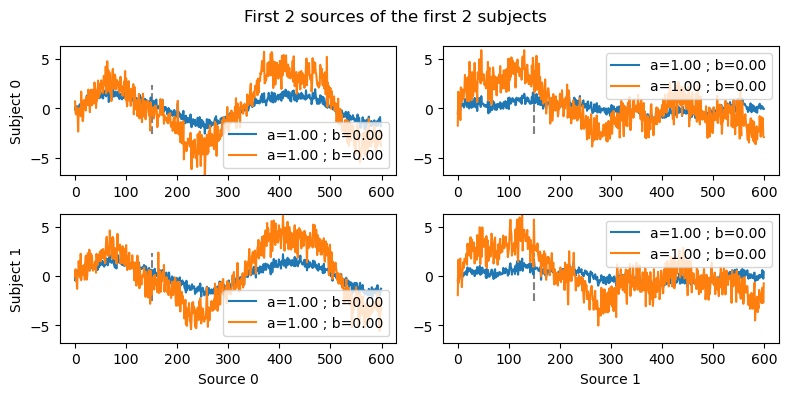

In [58]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.plot(
            Y_list_lbfgsb[i, order_lbfgsb[j]],
            label=f'a={dilations_lbfgsb[i, j]:.2f} ; b={shifts_lbfgsb[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim(
            [min(np.min(S_list), np.min(Y_list_lbfgsb)), 
             max(np.max(S_list), np.max(Y_list_lbfgsb))])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

In [23]:
dilations_lbfgsb_order = dilations_lbfgsb[:, order_lbfgsb]
shifts_lbfgsb_order = shifts_lbfgsb[:, order_lbfgsb]

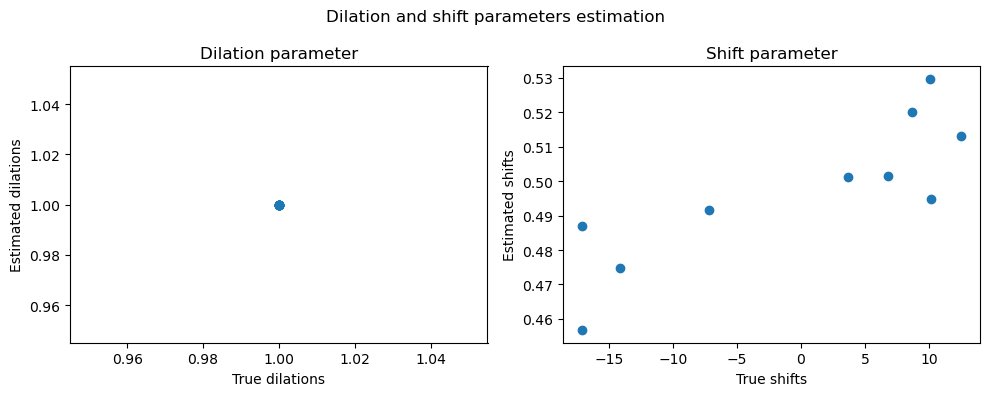

In [24]:
# colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# plot: compare estimated and true delays
plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(dilations, dilations_lbfgsb_order)
plt.xlabel("True dilations")
plt.ylabel("Estimated dilations")
plt.title("Dilation parameter")

plt.subplot(1, 2, 2)
plt.scatter(shifts, shifts_lbfgsb_order)
plt.xlabel("True shifts")
plt.ylabel("Estimated shifts")
plt.title("Shift parameter")

plt.suptitle("Dilation and shift parameters estimation")
plt.tight_layout()
plt.show()

Sometime we obtain dilation parameters equal to max_dilation or 1/max_dilation. It could be due to the boundary conditions. Maybe having cyclic boundary conditions will fix this problem and we will obtain better scatter plots.

# fmin_bfgs with previous _apply_delay() function

In [106]:
from multiviewica_delay import _apply_continuous_delays

def old_loss_function_fmin_bfgs(W_delays, X_list, noise_model):
    m, p, n = X_list.shape
    W_list, delays = W_delays[:m*p**2].reshape((m, p, p)), W_delays[m*p**2:].reshape((m, p))
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = _apply_continuous_delays(
        S_list=S_list,
        tau_list=-delays,
        shared_delays=False,
        multiple_subjects=True,
        use_jax=True,
    )
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

W_delays_old = jnp.concatenate([jnp.ravel(W_list_init), jnp.zeros(m * p)])

val_and_grad_fmin_bfgs_old = jax.jit(jax.value_and_grad(old_loss_function_fmin_bfgs))

# First call: slow because of compil
start = time()
val_and_grad_fmin_bfgs_old(W_delays_old, X_list, noise_model)
print(f"time : {time() - start}")

# Second call: fast thanks to jit
start = time()
val_and_grad_fmin_bfgs_old(W_delays_old, X_list, noise_model)
print(f"time : {time() - start}")

# def wrapper_fmin_bfgs_old(W_delays, X_list, noise_model):
#     loss, grad = val_and_grad_fmin_bfgs_old(W_delays, X_list, noise_model)
#     return loss, np.array(grad)

time : 5.096559286117554
time : 0.0028655529022216797


In [107]:
wrapper_loss = jax.jit(old_loss_function_fmin_bfgs)

def wrapper_grad(W_list_ravel, X_list, noise_model):
    _, grad = val_and_grad_fmin_bfgs_old(W_list_ravel, X_list, noise_model)
    return np.array(grad)

In [108]:
res_bfgs_old = fmin_bfgs(wrapper_loss, W_delays_old, fprime=wrapper_grad, args=(X_list, noise_model))

Optimization terminated successfully.
         Current function value: 6.990645
         Iterations: 89
         Function evaluations: 97
         Gradient evaluations: 97


In [97]:
# res_bfgs_old = fmin_bfgs(wrapper_fmin_bfgs_old, W_delays_old, args=(X_list, noise_model))

In [110]:
W_fmin_bfgs_old = res_bfgs_old[:m*p*p].reshape((m, p, p))
shifts_fmin_bfgs_old = res_bfgs_old[m*p*p:].reshape((m, p))

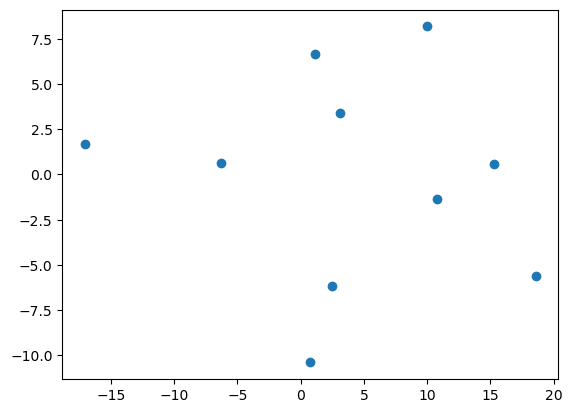

In [111]:
plt.scatter(shifts, shifts_fmin_bfgs_old)

# fmin_bfgs with new _apply_delay() function

In [ ]:
def loss_function_fmin_bfgs(W_list_ravel, X_list, noise_model):
    m, p, _ = X_list.shape
    W_list = W_list_ravel.reshape((m, p, p))
    Y_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

In [26]:
loss_function_fmin_bfgs(W_list_init, X_list, noise_model)

DeviceArray(0.67361686, dtype=float64)

In [27]:
val_and_grad = jax.jit(jax.value_and_grad(loss_function_fmin_bfgs))

In [28]:
# First call: slow because of compil
start = time()
val_and_grad(W_list_init, X_list, noise_model)
print(f"time : {time() - start}")

time : 2.2269599437713623


In [29]:
# Second call: fast thanks to jit
start = time()
val_and_grad(W_list_init, X_list, noise_model)
print(f"time : {time() - start}")

time : 0.0017058849334716797


In [30]:
wrapper_loss = jax.jit(loss_function_fmin_bfgs)

def wrapper_grad(W_list_ravel, X_list, noise_model):
    _, grad = val_and_grad(W_list_ravel,  X_list, noise_model)
    return np.array(grad)

In [31]:
from scipy.optimize import fmin_bfgs

In [32]:
res_bfgs = fmin_bfgs(wrapper_loss, W_list_init, fprime=wrapper_grad, args=(X_list, noise_model))

Optimization terminated successfully.
         Current function value: -4.821419
         Iterations: 72
         Function evaluations: 81
         Gradient evaluations: 81


In [36]:
W_fmin_bfgs = res_bfgs.reshape((m, p, p))

In [37]:
print("fmin_bfgs : ", np.mean([amari_distance(W, A) for W, A in zip(W_fmin_bfgs, A_list)]))

fmin_bfgs :  0.6041601606768879
